In [6]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
#from ff2_hTCN import ff2_hTCN
from sklearn import metrics
import torch.distributions as dist



In [7]:
kern = torch.ones(6,1,5)
kern[0:2] = 1
kern[2:4] = 2
kern[4:6] = 3

data = torch.ones(1,3,5)

prod = F.conv1d(data, kern, groups=3)
print(prod)

tensor([[[ 5.],
         [ 5.],
         [10.],
         [10.],
         [15.],
         [15.]]])


In [8]:
print(prod.shape)

torch.Size([1, 6, 1])


In [11]:
print(prod.reshape(3,2))

tensor([[ 5.,  5.],
        [10., 10.],
        [15., 15.]])


# Hyperparams

In [2]:
train_T = 40000
test_T = 4000
T_no = 100
M_no = 2
B_no = 2

C_den = torch.zeros(5,5)
C_den[0,1:] = 1

#C_den = torch.tensor([0]).reshape((1,1))
#C_den = torch.zeros(2,2)
#C_den[0,1:] = 1


sub_no = C_den.shape[0]

batch_size = 1500

In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
#Ensyn = torch.tensor([106+213+211+99])
#Insyn = torch.tensor([1+22+36+42+19])

#Ensyn = torch.tensor([0, 106+ 213+ 211+ 99])
#Insyn = torch.tensor([1, 22+ 36+ 42+ 19])

E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]
    
#######
#####
#C_syn = torch.hstack((C_syn_e, C_syn_i))

# Train

In [4]:
model = ff2_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model = model.float().cuda()

V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5.npy").flatten()[:]
#V_ref = np.fromfile("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
#V_ref = V_ref[1:]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([4000])


In [5]:
state_dict = model.state_dict()

for name, param in state_dict.items():
    # Transform the parameter as required.
    transformed_param = param * 0.25
    # Update the parameter.
    state_dict[name].copy_(transformed_param)

In [6]:
E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")
I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b5_neural.npy")

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

#######
#######
#train_S = torch.hstack((train_S_E, train_S_I)).float()
#test_S = torch.hstack((test_S_E, test_S_I)).float().cuda()

In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

77000
77000


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.5)


506


In [9]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))
#criterion = nn.MSELoss(reduction="mean")

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    #batch_S = train_S[batch_idx : batch_idx+batch_size].cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()

    loss = torch.var(batch_pred - batch_ref.flatten())
    #loss = torch.mean((batch_pred -  batch_ref) ** 2)
    
    loss = loss 
    
    loss.backward()
    #for name, p in model.named_parameters():
        #print(name, p.grad)

    
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        #test_loss = torch.mean((test_V_ref - test_pred) ** 2)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        #if i%100 == 0:
            #torch.save(model.state_dict(), "/media/hdd01/sklee/tcn/burst_L23_sub5_m2_i"+str(i)+".pt")
            #loss_array[i//100,0] = i
            #loss_array[i//100,1] = test_score
            #np.save("/media/hdd01/sklee/tcn/burst_L23_sub5_m2_test_scores.npy", loss_array)


<ipython-input-9-edcead2d1afd>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 39.708667538954856 0.003201066915827555 -0.00435030460357666
TEST 100 39.021455602710674 0.02045201405801922 0.027797281742095947
TEST 200 36.308137705565606 0.08856390372565615 0.07534259557723999
TEST 300 27.26458329655063 0.3155824854064194 0.3698856830596924
TEST 400 21.708209529169306 0.4550630519982861 0.524033784866333
TEST 500 17.64255023255507 0.5571225039354261 0.49054306745529175
TEST 600 15.022330243182804 0.6228973751326121 0.6792171597480774
TEST 700 12.5970126571084 0.6837796492300579 0.696259081363678
TEST 800 10.803218985697967 0.7288089018125513 0.7100759744644165
TEST 900 10.729784728276957 0.7306523077394997 0.6938554048538208
TEST 1000 8.434747521523034 0.7882641787963458 0.815886378288269
TEST 1100 7.9282205018846055 0.8009794276967477 0.808776319026947
TEST 1200 7.150807427601266 0.8204946765243616 0.8366237282752991
TEST 1300 6.228427635361893 0.8436489964206613 0.8631163239479065
TEST 1400 6.64263588174364 0.8332512077202106 0.7918006181716919
TEST 1500 

TEST 12400 4.0051139395308555 0.8994604063123844 0.8747314214706421
TEST 12500 3.949516781923934 0.9008560509098449 0.9032664895057678
TEST 12600 3.504134689403493 0.9120363906571026 0.8946005702018738
TEST 12700 3.8198793144879377 0.9041103149615495 0.8994858860969543
TEST 12800 3.320354890329618 0.916649779082297 0.8872095942497253
TEST 12900 3.866940619050115 0.9029289442226469 0.9054718017578125
TEST 13000 3.7037578354660106 0.9070252897821521 0.8770973086357117
TEST 13100 3.496773852630801 0.9122211683200696 0.9063181281089783
TEST 13200 3.316963663836045 0.9167349083615491 0.885260820388794
TEST 13300 3.5392391393602036 0.9111551704931891 0.8673208355903625
TEST 13400 3.9758713324099038 0.900194477773489 0.8807852268218994
TEST 13500 3.3975956784108305 0.9147108186475289 0.8630006313323975
TEST 13600 4.303134205324736 0.8919792617248894 0.885720431804657
TEST 13700 3.725101443028487 0.9064895053720635 0.8705865144729614
TEST 13800 3.306542534376302 0.9169965079602145 0.8233339190

KeyboardInterrupt: 

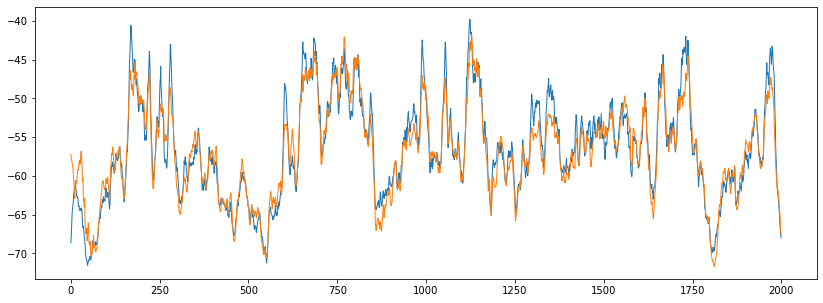

In [12]:
plt.figure(figsize=(14,5))
plt.plot(test_V_ref.cpu().detach().numpy()[:2000], linewidth=1)
plt.plot(test_pred.cpu().detach().numpy()[:2000] - 49, linewidth=1)
#plt.ylim(-100,0)

torch.Size([10, 100])


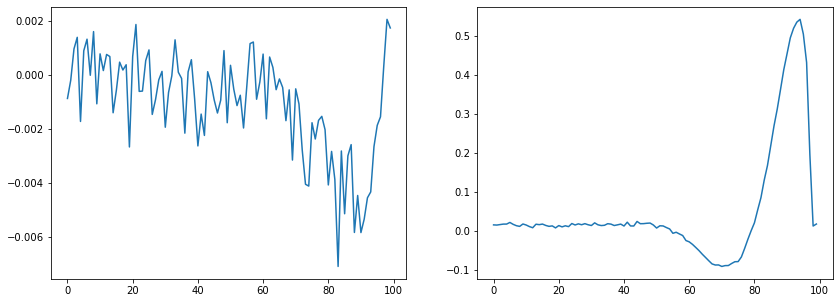

In [21]:
e_weights = torch.matmul(model.conv1_e_weights, model.conv1_e_bases)
i_weights = torch.matmul(model.conv1_i_weights, model.conv1_i_bases)
print(e_weights.shape)

fig, axs = plt.subplots(ncols=2, figsize = (14,5))
axs[0].plot(e_weights[9,:].cpu().detach().numpy())
axs[1].plot(i_weights[9,:].cpu().detach().numpy())

torch.Size([5, 100])


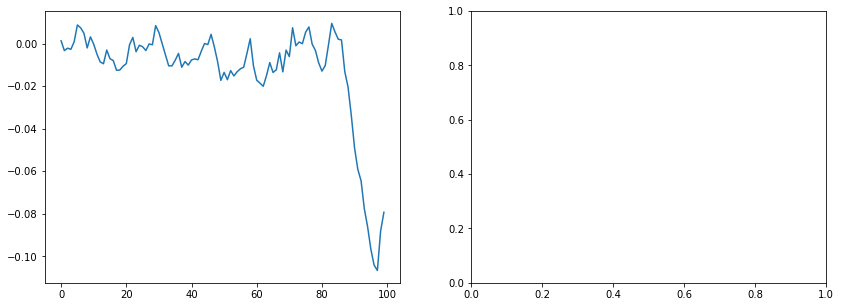

In [24]:
conv2_weights = torch.matmul(model.conv2_weights, model.conv2_bases)
print(e_weights.shape)

fig, axs = plt.subplots(ncols=2, figsize = (14,5))
axs[0].plot(conv2_weights[0,:].cpu().detach().numpy())